# GPT Excerpt Replacing

Replace hallucinated excerpts with valid excerpts from re-run questions until all questions have 3 valid excerpts

In [1]:
#Imports libraries
from google.oauth2 import service_account
from googleapiclient.discovery import build
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import pandas as pd
import numpy as np

In [2]:
#Setup Google Drive API Access
scopes = ["https://www.googleapis.com/auth/drive.readonly"]
service_file = "service_account.json"

creds = service_account.Credentials.from_service_account_file(
    service_file, scopes=scopes
)

drive = build("drive", "v3", credentials=creds)

In [3]:
# Build Sheets API client
sheets_service = build("sheets", "v4", credentials=creds)

#Oz Questions Spreadsheet ID and range
spreadsheet_id = "1aa61xgSOBXu6qH1chEiFqUxgFmBNyvr4Q5bSCFUOkt8"
spreadsheet_range = "Sheet1!A1:D100" 

#Call Oz Questions Spreadsheet
result = sheets_service.spreadsheets().values().get(
    spreadsheetId=spreadsheet_id,
    range=spreadsheet_range
).execute()

values = result.get("values", [])

#Convert to DataFrame
oz_questions_df = pd.DataFrame(values[1:], columns=values[0])

In [4]:
#Development questions to be dropped
drop_qs = pd.read_csv('/work/selected_oz_questions.csv')
drop_qs = drop_qs['Question'].tolist()

In [5]:
#Read in continuity checked results for run 1
df5_1 = pd.read_csv('/work/oz_extractor_5.1_1_is_match_results_CONT_CHECKED_2.csv')

#Drop questions 'Is Toto in Book 3, Ozma of Oz?', as the question was updated after run 1
df5_1 = df5_1[df5_1['question'] != 'Is Toto in Book 3, Ozma of Oz?']

#Drop questions from drop_qs list
df5_1 = df5_1[~df5_1['question'].isin(drop_qs)]

#Add column for run number
df5_1['run_number'] = 1

df5_1.head()

,question,question_number,result_rank,excerpt,filename,model_chunk_index,model_chapter_number,model_chapter_title,model_chunk_in_chapter_index,all_model_chunks,model_filename,excerpt_cleaned,run_number
0,What color are Dorothy's shoes?,1,1,"“Dorothy looked, and gave a little cry of frig...",book1_the_wonderful_wizard_of_oz_pg55_images,NaN,NaN,NaN,NaN,[],NaN,dorothy looked and gave a little cry of fright...,1
1,What color are Dorothy's shoes?,1,2,"““What is it?” asked the little old woman, and...",book1_the_wonderful_wizard_of_oz_pg55_images,16.0,2.0,The Council With The Munchkins,7.0,"[16, 17]",the_wonderful_wizard_of_oz,what is it? asked the little old woman and loo...,1
2,What color are Dorothy's shoes?,1,3,"“Dorothy had only one other dress, but that ha...",book1_the_wonderful_wizard_of_oz_pg55_images,22.0,3.0,How Dorothy Saved The Scarecrow,0.0,"[22, 23]",the_wonderful_wizard_of_oz,dorothy had only one other dress but that happ...,1
6,Which are the first antagonistic creatures the...,3,1,“The first day’s journey was through the green...,book1_the_wonderful_wizard_of_oz_pg55_images,220.0,19.0,Attacked By The Fighting Trees,3.0,"[220, 221, 222]",the_wonderful_wizard_of_oz,the first days journey was through the green f...,1
7,Which are the first antagonistic creatures the...,3,2,“There were few birds in this part of the fore...,book1_the_wonderful_wizard_of_oz_pg55_images,57.0,6.0,The Cowardly Lion,0.0,"[57, 58]",the_wonderful_wizard_of_oz,there were few birds in this part of the fores...,1


In [6]:
#Read in continuity checked results for run 2
df5_2 = pd.read_csv('/work/oz_extractor_5_2_is_match_results_CONT_CHECKED_1.csv')

#Drop questions from drop_qs list
df5_2 = df5_2[~df5_2['question'].isin(drop_qs)]

#Add column for run number
df5_2['run_number'] = 2

df5_2.head()

,question,question_number,result_rank,excerpt,filename,model_chunk_index,model_chapter_number,model_chapter_title,model_chunk_in_chapter_index,all_model_chunks,model_filename,excerpt_cleaned,run_number
0,What color are Dorothy's shoes?,1,1,"“Dorothy had only one other dress, but that ha...",book1_the_wonderful_wizard_of_oz_pg55_images,22.0,3.0,How Dorothy Saved The Scarecrow,0.0,"[22, 23]",the_wonderful_wizard_of_oz,dorothy had only one other dress but that happ...,2
1,What color are Dorothy's shoes?,1,2,"“Dorothy looked, and gave a little cry of frig...",book1_the_wonderful_wizard_of_oz_pg55_images,12.0,2.0,The Council With The Munchkins,3.0,"[12, 13]",the_wonderful_wizard_of_oz,dorothy looked and gave a little cry of fright...,2
2,What color are Dorothy's shoes?,1,3,“‘Your Silver Shoes will carry you over the de...,book1_the_wonderful_wizard_of_oz_pg55_images,252.0,23.0,Glinda The Good Witch Grants Dorothy’s Wish,5.0,"[252, 253]",the_wonderful_wizard_of_oz,your silver shoes will carry you over the dese...,2
6,Which are the first antagonistic creatures the...,3,1,“They found the forest very thick on this side...,book1_the_wonderful_wizard_of_oz_pg55_images,73.0,7.0,The Journey To The Great Oz,6.0,"[73, 74]",the_wonderful_wizard_of_oz,they found the forest very thick on this side ...,2
7,Which are the first antagonistic creatures the...,3,2,“They had just started to cross this queer bri...,book1_the_wonderful_wizard_of_oz_pg55_images,75.0,7.0,The Journey To The Great Oz,8.0,"[75, 76]",the_wonderful_wizard_of_oz,they had just started to cross this queer brid...,2


In [7]:
def replace_hallucinated_excerpts(master_df: pd.DataFrame, new_df: pd.DataFrame) -> pd.DataFrame:
    """
    Fills rows in master_df where 'model_filename' is NaN by replacing the entire row
    with an unused matching row from a new run's df.

    Matching is based on the 'question' column, and only non-NaN rows in new_df['model_filename']
    are considered as replacements. Each row in new_df can be used only once.

    Args:
        master_df: The base DataFrame to be modified.
        new_df: The DataFrame containing replacement data.

    Returns:
        The updated master_df.
    """
    # Create copy to make changes on
    master_df = master_df.copy()
    
    # Track the indices of new_df that have been used
    used_indices = set()

    # Iterate over the indices of master_df
    for index in master_df.index:
        # Check if the row needs a replacement (model_filename is NaN)
        if pd.isna(master_df.loc[index, 'model_filename']):
            
            # Get the question for matching
            question_value = master_df.loc[index, 'question']
            
            # Filter new_df for matching question and non-null fill column
            matching_rows = new_df[
                (new_df['question'] == question_value) & 
                new_df['model_filename'].notna()
            ]
            
            # Find the first unused matching row
            for idx, match_row in matching_rows.iterrows():
                if idx not in used_indices:
                    # Replace the entire row in master_df with the replacement row
                    master_df.loc[index] = match_row
                    
                    # Mark this index from new_df as used
                    used_indices.add(idx)
                    break
                    
    return master_df

In [8]:
# Replace hallucinated excerpts in df5_2 with those from df5_1
master_df = replace_hallucinated_excerpts(df5_2, df5_1)
master_df.head()

,question,question_number,result_rank,excerpt,filename,model_chunk_index,model_chapter_number,model_chapter_title,model_chunk_in_chapter_index,all_model_chunks,model_filename,excerpt_cleaned,run_number
0,What color are Dorothy's shoes?,1,1,"“Dorothy had only one other dress, but that ha...",book1_the_wonderful_wizard_of_oz_pg55_images,22.0,3.0,How Dorothy Saved The Scarecrow,0.0,"[22, 23]",the_wonderful_wizard_of_oz,dorothy had only one other dress but that happ...,2
1,What color are Dorothy's shoes?,1,2,"“Dorothy looked, and gave a little cry of frig...",book1_the_wonderful_wizard_of_oz_pg55_images,12.0,2.0,The Council With The Munchkins,3.0,"[12, 13]",the_wonderful_wizard_of_oz,dorothy looked and gave a little cry of fright...,2
2,What color are Dorothy's shoes?,1,3,“‘Your Silver Shoes will carry you over the de...,book1_the_wonderful_wizard_of_oz_pg55_images,252.0,23.0,Glinda The Good Witch Grants Dorothy’s Wish,5.0,"[252, 253]",the_wonderful_wizard_of_oz,your silver shoes will carry you over the dese...,2
6,Which are the first antagonistic creatures the...,3,1,“They found the forest very thick on this side...,book1_the_wonderful_wizard_of_oz_pg55_images,73.0,7.0,The Journey To The Great Oz,6.0,"[73, 74]",the_wonderful_wizard_of_oz,they found the forest very thick on this side ...,2
7,Which are the first antagonistic creatures the...,3,2,“They had just started to cross this queer bri...,book1_the_wonderful_wizard_of_oz_pg55_images,75.0,7.0,The Journey To The Great Oz,8.0,"[75, 76]",the_wonderful_wizard_of_oz,they had just started to cross this queer brid...,2


In [9]:
def get_unique_null_questions(df: pd.DataFrame) -> np.ndarray:
    """
    Returns an array of unique question strings where the 'model_filename'
    column is null (NaN). These questions can be used for rerunning the
    extraction process to get more unhallucinated results.

    Args:
        df: A DataFrame containing 'question' and 'model_filename' columns.

    Returns:
        A NumPy array of unique question strings that correspond to null 
        'model_filename' entries.
    """
    
    # Filter for rows where 'model_filename' is null 
    null_model_df = df[df['model_filename'].isnull()]
    
    # Return the unique questions from the filtered DataFrame
    return null_model_df['question'].unique()

In [10]:
# Extract questions that need to be rerun
rerun_questions = get_unique_null_questions(master_df)
rerun_questions

array(['How do you wind Tiktok?', 'What does Eureka look like?',
       'How does Dorothy return to Kansas in book 4, Dorothy and the Wizard in Oz?',
       'What are the Cuttenclips?', 'How is Mogodore defeated?'],
      dtype=object)

In [11]:
# Read in continuity checked results for run 3
df5_3 = pd.read_csv('/work/oz_extractor_5_3_is_match_results_CONT_CHECKED_1.csv')

#Drop questions from drop_qs list
df5_3 = df5_3[~df5_3['question'].isin(drop_qs)]

#Add column for run number
df5_3['run_number'] = 3

df5_3.head()

,question,question_number,result_rank,excerpt,filename,model_chunk_index,model_chapter_number,model_chapter_title,model_chunk_in_chapter_index,all_model_chunks,model_filename,excerpt_cleaned,run_number
3,"When is the first time we read ""There's no pla...",2,1,“That is because you have no brains” answered ...,book1_the_wonderful_wizard_of_oz_pg55_images,NaN,NaN,NaN,NaN,[],NaN,that is because you have no brains answered th...,3
4,"When is the first time we read ""There's no pla...",2,2,“That is because you have no brains” answered ...,book1_the_wonderful_wizard_of_oz_pg55_images,NaN,NaN,NaN,NaN,[],NaN,that is because you have no brains answered th...,3
5,"When is the first time we read ""There's no pla...",2,3,"“The Scarecrow listened carefully, and said, “...",book1_the_wonderful_wizard_of_oz_pg55_images,37.0,4.0,The Road Through The Forest,2.0,"[37, 38]",the_wonderful_wizard_of_oz,the scarecrow listened carefully and said i ca...,3
15,What is Ozma's back-story?,6,1,"“The Wizard brought to me the girl Ozma, who w...",book2_the_marvelous_land_of_oz_pg54_images,292.0,23.0,Princess Ozma Of Oz,6.0,"[292, 293, 294]",the_marvelous_land_of_oz,the wizard brought to me the girl ozma who was...,3
16,What is Ozma's back-story?,6,2,"“Well, when I was a baby girl I was stolen by ...",book7_the_patchwork_girl_of_oz_pg32094_images,247.0,17.0,Ozma And Her Friends,7.0,"[247, 248]",the_patchwork_girl_of_oz,well when i was a baby girl i was stolen by an...,3


In [12]:
# Replace hallucinated excerpts in master_df with those from df5_3
master_df = replace_hallucinated_excerpts(master_df, df5_3)
master_df.head()

,question,question_number,result_rank,excerpt,filename,model_chunk_index,model_chapter_number,model_chapter_title,model_chunk_in_chapter_index,all_model_chunks,model_filename,excerpt_cleaned,run_number
0,What color are Dorothy's shoes?,1,1,"“Dorothy had only one other dress, but that ha...",book1_the_wonderful_wizard_of_oz_pg55_images,22.0,3.0,How Dorothy Saved The Scarecrow,0.0,"[22, 23]",the_wonderful_wizard_of_oz,dorothy had only one other dress but that happ...,2
1,What color are Dorothy's shoes?,1,2,"“Dorothy looked, and gave a little cry of frig...",book1_the_wonderful_wizard_of_oz_pg55_images,12.0,2.0,The Council With The Munchkins,3.0,"[12, 13]",the_wonderful_wizard_of_oz,dorothy looked and gave a little cry of fright...,2
2,What color are Dorothy's shoes?,1,3,“‘Your Silver Shoes will carry you over the de...,book1_the_wonderful_wizard_of_oz_pg55_images,252.0,23.0,Glinda The Good Witch Grants Dorothy’s Wish,5.0,"[252, 253]",the_wonderful_wizard_of_oz,your silver shoes will carry you over the dese...,2
6,Which are the first antagonistic creatures the...,3,1,“They found the forest very thick on this side...,book1_the_wonderful_wizard_of_oz_pg55_images,73.0,7.0,The Journey To The Great Oz,6.0,"[73, 74]",the_wonderful_wizard_of_oz,they found the forest very thick on this side ...,2
7,Which are the first antagonistic creatures the...,3,2,“They had just started to cross this queer bri...,book1_the_wonderful_wizard_of_oz_pg55_images,75.0,7.0,The Journey To The Great Oz,8.0,"[75, 76]",the_wonderful_wizard_of_oz,they had just started to cross this queer brid...,2


In [13]:
# Extract questions that need to be rerun
rerun_questions = get_unique_null_questions(master_df)
rerun_questions

array(['How do you wind Tiktok?',
       'How does Dorothy return to Kansas in book 4, Dorothy and the Wizard in Oz?',
       'How is Mogodore defeated?'], dtype=object)

In [14]:
#Read in continuity checked results for run 4
df5_4 = pd.read_csv('/work/oz_extractor_5_4_1_is_match_results_CONT_CHECKED_2.csv')

#Drop questions from drop_qs list
df5_4 = df5_4[~df5_4['question'].isin(drop_qs)]

#Add column for run number
df5_4['run_number'] = 4

df5_4.head()


,question,question_number,result_rank,excerpt,filename,model_chunk_index,model_chapter_number,model_chapter_title,model_chunk_in_chapter_index,all_model_chunks,model_filename,excerpt_cleaned,run_number
6,How do you wind Tiktok?,3,1,"""She ran around the copper man to take the key...",book3_ozma_of_oz_pg33361_images,57.0,5.0,Dorothy Opens The Dinner Pail,1.0,"[57, 58]",ozma_of_oz,she ran around the copper man to take the key ...,4
7,How do you wind Tiktok?,3,2,"""""Now Tiktok,"" said Dorothy, ""the first thing ...",book3_ozma_of_oz_pg33361_images,56.0,5.0,Dorothy Opens The Dinner Pail,0.0,"[56, 57]",ozma_of_oz,now tiktok said dorothy the first thing to be ...,4
8,How do you wind Tiktok?,3,3,"""""It's Tik-tok and Billina; and oh! I'm so gla...",book5_the_road_to_ozpg26624_images,163.0,14.0,Tik-Tok And Billina,2.0,"[163, 164, 165]",the_road_to_oz,its tik tok and billina; and oh! im so glad to...,4
9,"How does Dorothy return to Kansas in book 4, D...",4,1,"""Dorothy was herself anxious to get home, so s...",book4_dorothy_and_the_wizard_in_ozpg22566_images,284.0,20.0,Zeb Returns To The Ranch,0.0,"[284, 285, 286]",dorothy_and_the_wizard_in_oz,dorothy was herself anxious to get home so she...,4
10,"How does Dorothy return to Kansas in book 4, D...",4,2,"""Early the following morning they were all gat...",book4_dorothy_and_the_wizard_in_ozpg22566_images,NaN,NaN,NaN,NaN,[],NaN,early the following morning they were all gath...,4


In [15]:
# Replace hallucinated excerpts in master_df with those from df5_4
master_df = replace_hallucinated_excerpts(master_df, df5_4)
master_df.head()

,question,question_number,result_rank,excerpt,filename,model_chunk_index,model_chapter_number,model_chapter_title,model_chunk_in_chapter_index,all_model_chunks,model_filename,excerpt_cleaned,run_number
0,What color are Dorothy's shoes?,1,1,"“Dorothy had only one other dress, but that ha...",book1_the_wonderful_wizard_of_oz_pg55_images,22.0,3.0,How Dorothy Saved The Scarecrow,0.0,"[22, 23]",the_wonderful_wizard_of_oz,dorothy had only one other dress but that happ...,2
1,What color are Dorothy's shoes?,1,2,"“Dorothy looked, and gave a little cry of frig...",book1_the_wonderful_wizard_of_oz_pg55_images,12.0,2.0,The Council With The Munchkins,3.0,"[12, 13]",the_wonderful_wizard_of_oz,dorothy looked and gave a little cry of fright...,2
2,What color are Dorothy's shoes?,1,3,“‘Your Silver Shoes will carry you over the de...,book1_the_wonderful_wizard_of_oz_pg55_images,252.0,23.0,Glinda The Good Witch Grants Dorothy’s Wish,5.0,"[252, 253]",the_wonderful_wizard_of_oz,your silver shoes will carry you over the dese...,2
6,Which are the first antagonistic creatures the...,3,1,“They found the forest very thick on this side...,book1_the_wonderful_wizard_of_oz_pg55_images,73.0,7.0,The Journey To The Great Oz,6.0,"[73, 74]",the_wonderful_wizard_of_oz,they found the forest very thick on this side ...,2
7,Which are the first antagonistic creatures the...,3,2,“They had just started to cross this queer bri...,book1_the_wonderful_wizard_of_oz_pg55_images,75.0,7.0,The Journey To The Great Oz,8.0,"[75, 76]",the_wonderful_wizard_of_oz,they had just started to cross this queer brid...,2


In [16]:
# Extract questions that need to be rerun
rerun_questions = get_unique_null_questions(master_df)
rerun_questions

array([], dtype=object)

In [17]:
# Set dfs in a list and their names 
df_list = [df5_1, df5_2, df5_3, df5_4]
df_names = ['df5_1', 'df5_2', 'df5_3', 'df5_4']

# Initialize dictionaries
null_counts = {}
non_null_counts = {}

# Convert 'Question' to lowercase and strip whitespace for better merging
oz_questions_df['Question'] = oz_questions_df['Question'].str.lower().str.strip()

# Define the columns and merge arguments
merge_cols = ['Question', 'Book #']
merge_kwargs = {
    'left_on': 'question',
    'right_on': 'Question',
    'how': 'left',

}

# Loop through each dataframe
for df, name in zip(df_list, df_names):
    
    # Convert 'question' to lowercase and strip whitespace before filtering/merging
    df['question'] = df['question'].str.lower().str.strip()
    
    # Extract null rows
    null_df = df[df['model_filename'].isnull()].copy()
    
    # Merge to map book number
    null_df = null_df.merge(oz_questions_df[merge_cols], **merge_kwargs)
    null_df.drop('Question', axis=1, inplace=True)

    # Get the count from each 'Book #' and store it
    null_counts[name] = null_df['Book #'].value_counts()

    # Extract not null rows
    non_null_df = df[df['model_filename'].notnull()].copy()
    
    # Merge to map book numbers
    non_null_df = non_null_df.merge(oz_questions_df[merge_cols], **merge_kwargs)
    non_null_df.drop('Question', axis=1, inplace=True)

    # Get the count from each 'Book #' and store it
    non_null_counts[name] = non_null_df['Book #'].value_counts()

# Null Counts DataFrame
result_null_df = pd.DataFrame(null_counts).fillna(0).astype(int)
result_null_df['Total'] = result_null_df.sum(axis=1)
grand_total_nulls = result_null_df['Total'].sum()

# Non-Null Counts DataFrame
result_non_null_df = pd.DataFrame(non_null_counts).fillna(0).astype(int)
result_non_null_df['Total'] = result_non_null_df.sum(axis=1)
grand_total_non_nulls = result_non_null_df['Total'].sum()


print("--- Counts of Rows with NULL 'model_filename' ---")
print(result_null_df)

print("\n--- Counts of Rows with NON-NULL 'model_filename' ---")
print(result_non_null_df)

print(f"\n--- Grand Totals ---")
print(f"Total Count of ALL Nulls: {grand_total_nulls}")
print(f"Total Count of ALL Non-Nulls: {grand_total_non_nulls}")

--- Counts of Rows with NULL 'model_filename' ---
        df5_1  df5_2  df5_3  df5_4  Total
Book #                                   
1           1      0      2      0      3
15          8      6      3      1     18
2           7      2      0      0      9
3           6      8      4      0     18
4           9      8      3      2     22
5           5      7      2      0     14
6           9      3      2      0     14
7           7      4      7      0     18

--- Counts of Rows with NON-NULL 'model_filename' ---
        df5_1  df5_2  df5_3  df5_4  Total
Book #                                   
1          14     18      1      0     33
15         13     15      3      2     33
2          11     16      0      0     27
3           9      7      8      3     27
4           9     10      6      1     26
5          13     11      4      0     28
6          15     18      4      0     37
7          14     17      5      0     36

--- Grand Totals ---
Total Count of ALL Nulls: 116
Tot

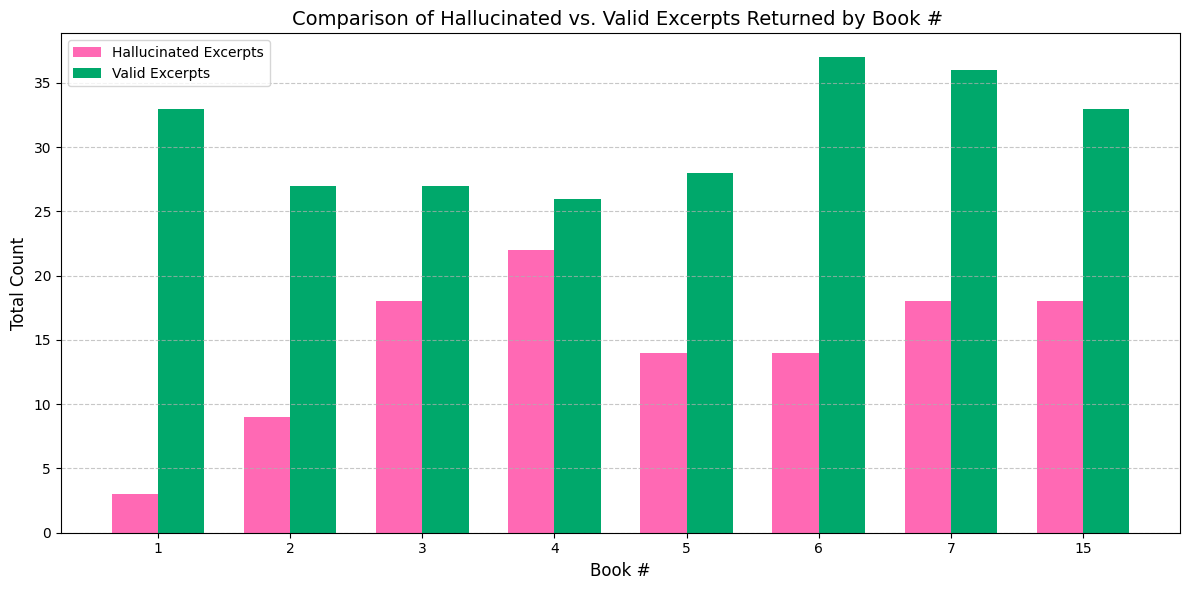

In [21]:
# Combine the 'Total' columns into a single DataFrame
plot_df = pd.DataFrame({
    'Null Counts': result_null_df['Total'],
    'Non-Null Counts': result_non_null_df['Total']
})

plot_df.index = plot_df.index.astype(int)
plot_df = plot_df.sort_index(ascending=True)

# Define bar parameters
# Convert index back to string for plotting labels
book_numbers = plot_df.index.astype(str)
null_counts = plot_df['Null Counts']
non_null_counts = plot_df['Non-Null Counts']

x = range(len(book_numbers))
width = 0.35 # Bar width

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for Null Counts
rects1 = ax.bar([i - width/2 for i in x], null_counts, width, label='Hallucinated Excerpts', color='#FF69B4')

# Plot bars for Non-Null Counts
rects2 = ax.bar([i + width/2 for i in x], non_null_counts, width, label='Valid Excerpts', color='#00A86B')

# Add labels, title, and x-axis tick labels
ax.set_ylabel('Total Count', fontsize=12)
ax.set_xlabel('Book #', fontsize=12)
ax.set_title('Comparison of Hallucinated vs. Valid Excerpts Returned by Book # ', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(book_numbers)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f3468430-3cb1-4d6e-8fbc-21329270417f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>